In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import matplotlib.pyplot as plt
import seaborn

In [2]:
data = pd.read_csv("Workshop_Backtest.csv")

In [3]:
data

,datetime,CF,SR,TA,al,au,c,cu,l,m,p,rb,ru,v,y,zn
0,2010/1/5,0.011700,0.010348,0.011220,0.048953,0.011921,0.012156,0.034943,0.005915,0.011528,0.012012,0.010009,0.028698,0.000648,0.010202,0.041029
1,2010/1/6,-0.024954,-0.035594,-0.031634,-0.043162,-0.016297,-0.009922,-0.028508,-0.033712,-0.030935,-0.040734,-0.033175,-0.010413,-0.019430,-0.033251,-0.038521
2,2010/1/7,0.006552,-0.029944,0.007801,0.009022,0.029701,0.015823,0.019672,0.006085,0.005376,0.006187,0.000446,0.018066,-0.004624,0.002293,0.002316
3,2010/1/8,0.003254,-0.000179,-0.007741,0.013691,-0.005040,-0.006231,-0.009486,-0.000806,-0.011698,-0.015651,0.001782,0.007605,-0.009954,-0.018302,-0.006932
4,2010/1/11,-0.025361,-0.007719,-0.013896,-0.049063,-0.026535,-0.014107,-0.037981,-0.050040,-0.029422,-0.037763,-0.020231,-0.027869,-0.022788,-0.031072,-0.046999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2021/6/23,0.000945,-0.002906,-0.002797,-0.004259,-0.001391,-0.001161,-0.003336,0.008197,-0.003260,-0.015468,-0.006221,0.006939,-0.013458,-0.012977,-0.001369
2786,2021/6/24,0.008816,0.008927,0.036859,0.018979,-0.000107,0.002713,0.002329,0.013759,0.010110,0.022112,0.028271,0.007657,0.013642,0.019102,0.002742
2787,2021/6/25,0.002809,0.000181,0.002318,-0.011280,-0.003323,0.007731,-0.005663,0.016039,0.013247,0.003985,0.006088,-0.003419,0.016969,-0.010224,-0.010255
2788,2021/6/28,0.000000,0.007222,-0.016962,0.000796,-0.014412,0.002301,-0.007886,-0.006072,0.007844,0.012759,-0.010346,-0.018300,0.001726,0.012051,0.006447


In [4]:
numeric_data = data.iloc[:,1:]

<AxesSubplot:>

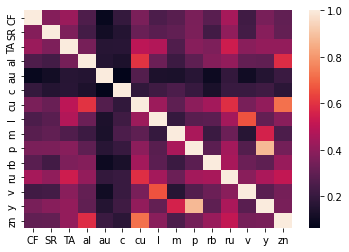

In [5]:
seaborn.heatmap(numeric_data.corr())

In [6]:
def sharpe_ratio(actualReturn, signals):
    assert actualReturn.shape == signals.shape
    dailyReturns = (actualReturn * signals)
    if(dailyReturns.shape[1] > 1):
        dailyReturns = dailyReturns.mean(axis=1)
    return dailyReturns.mean() / dailyReturns.std() * np.sqrt(240)

# 0.Benchmark

Linear regression

在excel中，给定benchmark实际上是使用前20天的数据作为窗口进行线性回归， 然后使用当天回报率去预测明天的回报率
x=(前21天-前1天)
y=(前20天-今天)

## 验证一下算法

In [7]:
trainWindow = 20

pdata = numeric_data['p']
signal = np.zeros(len(pdata) - trainWindow - 1).reshape(-1, 1)
for i in range(trainWindow + 1, len(pdata)):
    x = pdata[i - trainWindow - 1: i - 1].to_numpy().reshape(-1,1)
    y = pdata[i - trainWindow: i].to_numpy().reshape(-1,1)
    regressor = LinearRegression()
    regressor.fit(x, y)
    signal[i - trainWindow - 1] = 1 if regressor.predict(pdata[i-1].reshape(-1,1)) > 0 else -1

In [8]:
sharpe_ratio(pdata.iloc[trainWindow + 1:].to_numpy().reshape(-1,1),signal)

0.4339724650673047

## 1.Benchmark v0

将线性回归推广到全部产品，规定回测期为17年起

In [9]:
class singleFeatureDataLoader:
    
    def __init__(self, data_series, window_size=20):
        self.x = data_series.iloc[:-1].to_numpy().reshape(-1,1)
        self.y = data_series.iloc[1:].to_numpy().reshape(-1,1)
        self.window_size = window_size
        self._cnt = 0
        
    def __len__(self):
        return len(self.x) - self.window_size
    
    def __getitem__(self, index):
        return self.x[index :index+self.window_size], self.y[index:index+self.window_size]
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._cnt == self.__len__():
            self._cnt = 0
            raise StopIteration
        self._cnt += 1
        return self.__getitem__(self._cnt - 1)

In [10]:
bt_begin_at = data[data['datetime'] >= '2017/1/1'].iloc[0].name
bt_data = data.iloc[bt_begin_at-21:,1:]    

In [11]:
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns)))
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = singleFeatureDataLoader(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        model = LinearRegression().fit(x, y)
        test_x = y[-1].reshape(-1,1)
        signals[i, col_index] = model.predict(test_x)
signals = np.where(signals > 0, 1, -1)

In [12]:
actual_returns = data[data['datetime'] >= '2017/1/1'].iloc[:, 1:].to_numpy()

In [13]:
sharpe_ratio(actual_returns, signals)

0.2794710431588451

## 2.Benchmark v0.1

将特征拓展到10维（使用前10天的数据去预测第11天的数据）

每次使用时间窗口内的数据进行建模（20天）

In [14]:
class DataLoaderV01:
    
    def __init__(self, data_series, window_size=21, feature_size=10):
        self.x = data_series.iloc[:-1].to_numpy().reshape(-1,1)
        self.y = data_series.iloc[feature_size:].to_numpy().reshape(-1,1)
        self.window_size = window_size
        self.feature_size = feature_size
        self.sample_number_per_window = window_size - feature_size - 1
        self._cnt = 0
        
    def __len__(self):
        return len(self.y) - self.window_size
    
    def __getitem__(self, index):
        x_mat = np.zeros((self.sample_number_per_window, self.feature_size)) # (9, 10)
        y_mat = np.zeros((self.sample_number_per_window,1)).reshape(-1,1)
        for i in range(self.sample_number_per_window):
            x_mat[i] = self.x[index + i :index+i+self.feature_size].T
            y_mat[i] = self.y[index + i]
        return x_mat, y_mat
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._cnt == self.__len__():
            self._cnt = 0
            raise StopIteration
        self._cnt += 1
        return self.__getitem__(self._cnt - 1)

In [15]:
bt_begin_at = data[data['datetime'] >= '2017/1/1'].iloc[0].name
bt_data = data.iloc[bt_begin_at-21:,1:]

In [16]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        model = LinearRegression().fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)

In [17]:
actual_returns = data[data['datetime'] >= '2017/1/1'].iloc[:, 1:].to_numpy()

In [18]:
sharpe_ratio(actual_returns, signals)

0.2473836178386532

# Benchmark V0.2

使用正则化

In [19]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        model = Lasso().fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)

In [20]:
sharpe_ratio(actual_returns, signals)

0.7404937060285496

In [21]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        model = Ridge().fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)

In [22]:
sharpe_ratio(actual_returns, signals)

0.7387223454244493

In [23]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        model = ElasticNet().fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)

In [24]:
sharpe_ratio(actual_returns, signals)

0.7404937060285496

# Benchmark V0.3

尝试一下SVR算法

In [25]:
from sklearn import svm

In [39]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        y = y.reshape(-1)
        model = svm.SVR(kernel='linear',C=.05).fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)

In [40]:
sharpe_ratio(actual_returns, signals)

0.44697083360188383

换成rbf核函数

In [44]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in enumerate(bt_data.columns):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in range(len(dataloader)):
        x, y = dataloader[i]
        y = y.reshape(-1)
        model = svm.SVR(kernel='rbf',C=.05).fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

0.44697083360188383

# Benchmark V0.4

Bagging ensembling

In [53]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

In [57]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in tqdm(enumerate(bt_data.columns)):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in tqdm(range(len(dataloader))):
        x, y = dataloader[i]
        y = y.reshape(-1)
        model = RandomForestRegressor(n_estimators=10,min_samples_split=2, random_state=42).fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

0it [00:00, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

0.15616794462685554

# Benchmark V0.5

Boost ensembling

In [55]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

In [58]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in tqdm(enumerate(bt_data.columns)):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in tqdm(range(len(dataloader))):
        x, y = dataloader[i]
        y = y.reshape(-1)
        model = AdaBoostRegressoraBoostRegressor(n_estimators=100).fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

0it [00:00, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

0.2367312974317425

In [62]:
# GBDT
from sklearn.ensemble import GradientBoostingRegressor

In [64]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in tqdm(enumerate(bt_data.columns)):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in tqdm(range(len(dataloader))):
        x, y = dataloader[i]
        y = y.reshape(-1)
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=1., random_state=42).fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

0it [00:00, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

0.2162605592313032

In [66]:
# xgboost
from xgboost import XGBRegressor

In [67]:
# N days of n product
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index, col_name in tqdm(enumerate(bt_data.columns)):
    dataloader = DataLoaderV01(bt_data[col_name])
    for i in tqdm(range(len(dataloader))):
        x, y = dataloader[i]
        y = y.reshape(-1)
        model = XGBRegressor(n_estimators=100, random_state=42).fit(x, y)
        signals[i, col_index] = model.predict(y.reshape(1, -1))
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

0it [00:00, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

  0%|          | 0/1081 [00:00<?, ?it/s]

0.7798333564104206

# Benchmark V0.6

Deep Learning

In [ ]:
# MLP

In [75]:
class MLP(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input = torch.nn.Linear(in_features=10, out_features=32)
        self.fc = torch.nn.Linear(in_features=32, out_features=10)
        self.out = torch.nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        x = self.input(x)
        x = torch.sigmoid(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        x = self.out(x)
        return x

In [94]:
class DatasetDL(torch.utils.data.Dataset):
    
    def __init__(self, data_series, feature_size=10):
        x = torch.Tensor(data_series.iloc[:-1].to_numpy().reshape(-1,1)).to('cuda')
        self.y = torch.Tensor(data_series.iloc[feature_size:].to_numpy().reshape(-1,1)).to('cuda')
        self.feature_size = feature_size
        
        self.x = torch.zeros((len(self.y), self.feature_size)).to('cuda')
        for i in range(len(self.y)):
            self.x[i] = x[i :i+self.feature_size].T
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [81]:
training_df = data.iloc[:bt_begin_at,1:]
bt_df = data.iloc[bt_begin_at-10:, 1:]

In [117]:
signals = np.zeros((len(data[data['datetime'] >= '2017/1/1']), len(bt_data.columns))) # (N * n)
for col_index in tqdm(range(len(bt_data.columns))):
    col_name = bt_data.columns[col_index]
    trainloader = torch.utils.data.DataLoader(DatasetDL(training_df[col_name]), batch_size=32)
    testloader = torch.utils.data.DataLoader(DatasetDL(bt_df[col_name]), batch_size=32)
    
    model = MLP().to("cuda")
    
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    lossfunc = torch.nn.MSELoss()
    
    # for e in tqdm(range(10)):
    for e in range(100):
        epoch_loss = []
        # for x, y in tqdm(trainloader):
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = lossfunc(y, yhat)
            loss.backward()
            optimizer.step()
            epoch_loss.append(torch.mean(loss).item())
        # print(f"epoch{e}, trainloss={np.mean(epoch_loss)}", end="")
        epoch_test_loss = []
        # for x, y in tqdm(testloader):
        for x, y in testloader:
            yhat = model(x)
            loss = lossfunc(y, yhat)
            epoch_test_loss.append(torch.mean(loss).item())
        # print(f"test loss={np.mean(epoch_test_loss)}")
    
    col_signals = []
    # for x, _ in tqdm(testloader):
    for x, _ in testloader:
        yhat = model(x)
        col_signals.append(yhat.to('cpu').detach().numpy())
    signals[...,col_index] = np.vstack(col_signals).reshape(-1)
signals = np.where(signals > 0, 1, -1)
sharpe_ratio(actual_returns, signals)

  0%|          | 0/15 [00:00<?, ?it/s]

0.3689484575939914

In [ ]:
# cnn